In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import re

In [3]:
df = pd.read_csv('tweets.csv')
df.head()

,Unnamed: 0,tweet_text,tweet_favourite_count,tweet_created_at,tweet_retweet_count,user_statuses_count,user_screen_name,user_followers_count
0,0,The priority for the city should be on providi...,0,2023-03-27 21:01:36+00:00,0,10194,EmergencyAgent,1145
1,1,"Like it or not, this kind of clip is the sort ...",0,2023-03-27 21:01:26+00:00,0,2843,EDenhoff,4630
2,2,On a scale of moderately conservative (1) to r...,0,2023-03-27 21:01:16+00:00,0,13608,dzoolander85,11234
3,3,Keep up with the latest politics with The Dail...,0,2023-03-27 21:01:06+00:00,0,3610,VassKapelosShow,4901
4,4,So much resemblance to NAZI Germany leading up...,0,2023-03-27 21:01:05+00:00,0,108226,marshiehilgs,515


# Exploratory Analysis

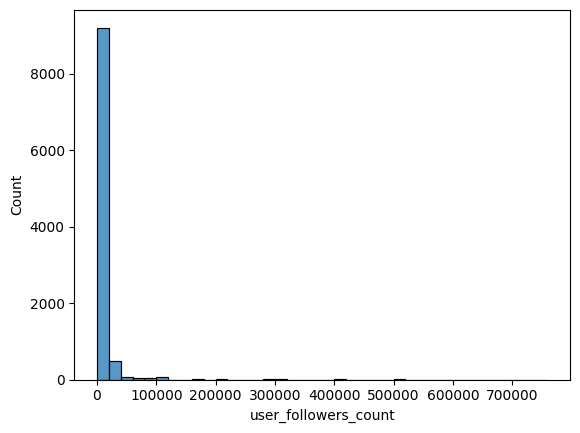

In [39]:
sns.histplot(df['user_followers_count'], binwidth=20000)
plt.show()

In [4]:
def group_followers(num_followers: int) -> str:
    if 0 <= num_followers <= 1000:
        return 'Few'
    elif 1000 < num_followers <= 10000:
        return 'Medium'
    else:
        return 'Many'

In [5]:
df['followers_group'] = df['user_followers_count'].apply(group_followers)

In [6]:
df.head()

,Unnamed: 0,tweet_text,tweet_favourite_count,tweet_created_at,tweet_retweet_count,user_statuses_count,user_screen_name,user_followers_count,followers_group
0,0,The priority for the city should be on providi...,0,2023-03-27 21:01:36+00:00,0,10194,EmergencyAgent,1145,Medium
1,1,"Like it or not, this kind of clip is the sort ...",0,2023-03-27 21:01:26+00:00,0,2843,EDenhoff,4630,Medium
2,2,On a scale of moderately conservative (1) to r...,0,2023-03-27 21:01:16+00:00,0,13608,dzoolander85,11234,Many
3,3,Keep up with the latest politics with The Dail...,0,2023-03-27 21:01:06+00:00,0,3610,VassKapelosShow,4901,Medium
4,4,So much resemblance to NAZI Germany leading up...,0,2023-03-27 21:01:05+00:00,0,108226,marshiehilgs,515,Few


In [7]:
df['followers_group'].value_counts()

Medium    4371
Few       4216
Many      1413
Name: followers_group, dtype: int64

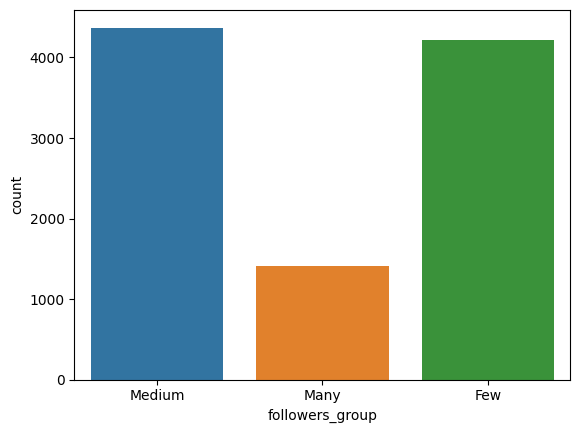

In [8]:
sns.countplot(x=df['followers_group'])
plt.show()

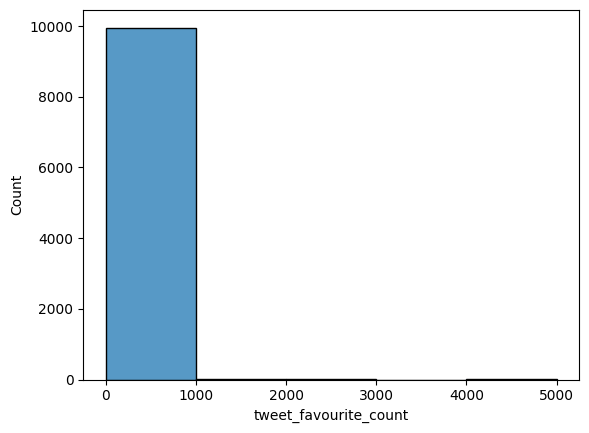

In [9]:
sns.histplot(df['tweet_favourite_count'], binwidth=1000)
plt.show()

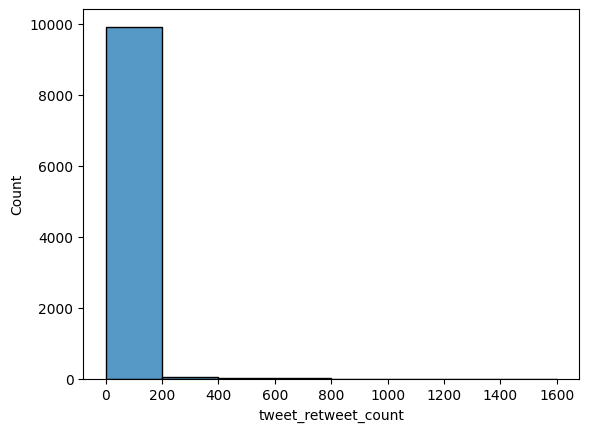

In [10]:
sns.histplot(df['tweet_retweet_count'], binwidth=200)
plt.show()

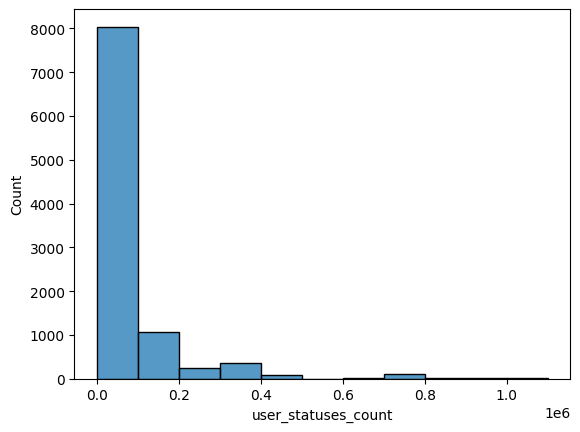

In [11]:
sns.histplot(df['user_statuses_count'], binwidth=100000)
plt.show()

# Preprocessing

In [12]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
nlp.add_pipe('sentencizer')

In [22]:
def remove_end_link(tweet: str) -> str:
    return tweet[:tweet.find('https://t.co/')]

def remove_whitespaces(tweet: str) -> str:
    return re.sub(r'\s{1,}', ' ', tweet).strip()

def tokenize_and_lemmatize(tweet: str) -> str:
    tweet_doc = nlp(tweet)
    result = ''
    for sent in tweet_doc.sents:
        sentence = ''
        for token in sent:
            lemma = token.lemma_.lower()
            tag = token.tag_
            sentence += lemma + '/' + tag + ' '
        result += sentence.strip()
    return result

def pipeline(tweet: str) -> str:
    step1 = remove_end_link(tweet)
    step2 = remove_whitespaces(step1)
    step3 = tokenize_and_lemmatize(step2)
    return step3

In [24]:
df['tweet_preprocessed'] = df['tweet_text'].apply(pipeline)
df.head()

,Unnamed: 0,tweet_text,tweet_favourite_count,tweet_created_at,tweet_retweet_count,user_statuses_count,user_screen_name,user_followers_count,followers_group,tweet_preprocessed
0,0,The priority for the city should be on providi...,0,2023-03-27 21:01:36+00:00,0,10194,EmergencyAgent,1145,Medium,the/DT priority/NN for/IN the/DT city/NN shoul...
1,1,"Like it or not, this kind of clip is the sort ...",0,2023-03-27 21:01:26+00:00,0,2843,EDenhoff,4630,Medium,"like/IN it/PRP or/CC not/RB ,/, this/DT kind/N..."
2,2,On a scale of moderately conservative (1) to r...,0,2023-03-27 21:01:16+00:00,0,13608,dzoolander85,11234,Many,on/IN a/DT scale/NN of/IN moderately/RB conser...
3,3,Keep up with the latest politics with The Dail...,0,2023-03-27 21:01:06+00:00,0,3610,VassKapelosShow,4901,Medium,keep/VB up/RP with/IN the/DT late/JJS politic/...
4,4,So much resemblance to NAZI Germany leading up...,0,2023-03-27 21:01:05+00:00,0,108226,marshiehilgs,515,Few,so/RB much/JJ resemblance/NN to/IN nazi/VB ger...


# Feature Extraction

In [31]:
# 0: pound signs
# 1: personal pronouns
# 2: proper nouns
# 3: wh- words
# 4: past tense verbs
def extract_features(tweet_preprocessed: str) -> np.array:
    result = np.zeros(10)
    tokens = tweet_preprocessed.split()
    for token in tokens:
        slash = token.find('/')
        lemma = token[:slash]
        tag = token[slash:]
        if lemma == '#':
            result[0] += 1
        elif tag in ['/PRP', '/PRP$']:
            result[1] += 1 
        elif tag in ['/NNP', '/NNPS']:
            result[2] += 1
        elif tag in ['/WDT', '/WP', '/WP$', '/WRB']:
            result[3] += 1
        elif tag == '/VBD':
            result[4] += 1
    return result